In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

##### **Load the Data**

In [41]:
customers_df = pd.read_csv("Data/Customers.csv")  
products_df = pd.read_csv("Data/Products.csv")  
transactions_df = pd.read_csv("Data/Transactions.csv")

##### **Merge transactions with product and customer details**

In [42]:
transactions_data=transactions_df.merge(products_df,how='left',on='ProductID')
data=transactions_data.merge(customers_df,how='left',on='CustomerID')

In [43]:
data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,SoundWave Smartwatch,Electronics,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,SoundWave Smartwatch,Electronics,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,SoundWave Smartwatch,Electronics,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,SoundWave Smartwatch,Electronics,459.86,Joshua Hamilton,Asia,2024-11-11


##### **Feature Engineering**

In [44]:
customer_data=data.groupby('CustomerID').agg(
    total_spent=('TotalValue','sum'),
    total_transactions=('TransactionID','count'),
    avg_order_value=('TotalValue','mean'),
    distinct_products=('ProductID','nunique')
).reset_index()

In [45]:
customer_data

,CustomerID,total_spent,total_transactions,avg_order_value,distinct_products
0,C0001,3354.52,5,670.904000,5
1,C0002,1862.74,4,465.685000,4
2,C0003,2725.38,4,681.345000,4
3,C0004,5354.88,8,669.360000,8
4,C0005,2034.24,3,678.080000,3
...,...,...,...,...,...
194,C0196,4982.88,4,1245.720000,3
195,C0197,1928.65,3,642.883333,3
196,C0198,931.83,2,465.915000,2
197,C0199,1979.28,4,494.820000,4


##### **Standardize Feature**

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
features=['total_spent','total_transactions','avg_order_value','distinct_products']

In [48]:
scaler=StandardScaler()
customer_data_scaled=scaler.fit_transform(customer_data[features])

##### **Train KNN Model**

In [49]:
from sklearn.neighbors import NearestNeighbors

In [50]:
model=NearestNeighbors(n_neighbors=4,metric="euclidean")

In [51]:
model.fit(customer_data_scaled)

NearestNeighbors(metric='euclidean', n_neighbors=4)

##### **To Find Similar Customers**

In [52]:
def find_similar_customers(customer_id, n_neighbors=3):
    index = customer_data[customer_data["CustomerID"] == customer_id].index[0]
    distance, indices = model.kneighbors([customer_data_scaled[index]])
    max_distance = max(distance[0][1:])
    similar_customers = [
        (customer_data.iloc[indices[0][i]]["CustomerID"], round((1 - (distance[0][i] / max_distance)) * 100, 2))
        for i in range(1, n_neighbors + 1)
    ]
    return similar_customers
    

##### **Generate Lookalike.csv for first 20 customers**

In [53]:
lookalike_data={}
for cust_id in customers_df["CustomerID"].head(20):
    lookalike_data[cust_id]=find_similar_customers(cust_id)

##### **Convert to Dataframe and save**

In [54]:
lookalike_df=pd.DataFrame(list(lookalike_data.items()),columns=["customerID","Lookalikes"])
lookalike_df.to_csv("Lookalike.csv",index=False)

##### **Model Evaluation using K-Fold Cross Validation**

In [55]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)
errors=[]
errors_sim=[]

In [63]:
for train_index, test_index in kf.split(customer_data_scaled):
    knn=NearestNeighbors(n_neighbors=4,metric="euclidean")
    knn.fit(customer_data_scaled[train_index])
    
    similarities=cosine_similarity(customer_data_scaled[test_index],customer_data_scaled[train_index])
    predicted_similarities=np.zeros_like(similarities)
    
    distances,_=knn.kneighbors(customer_data_scaled[test_index])
    
    mse_sim=mean_squared_error(similarities,predicted_similarities)
    errors_sim.append(mse_sim)
    
    mse=mean_squared_error(np.zeros_like(distances[:,1:]),distances[:,1:])
    errors.append(mse)
    

In [66]:
mse_euclidean = np.mean(errors)
mse_cosine = np.mean(errors_sim)

print(f"Mean Squared Error (Euclidean): {mse_euclidean:.4f}")
print(f"Mean Squared Error (Cosine Similarity): {mse_cosine:.4f}")

Mean Squared Error (Euclidean): 0.3072
Mean Squared Error (Cosine Similarity): 0.5028


##### **Visualization: Similarity Score Distribution**

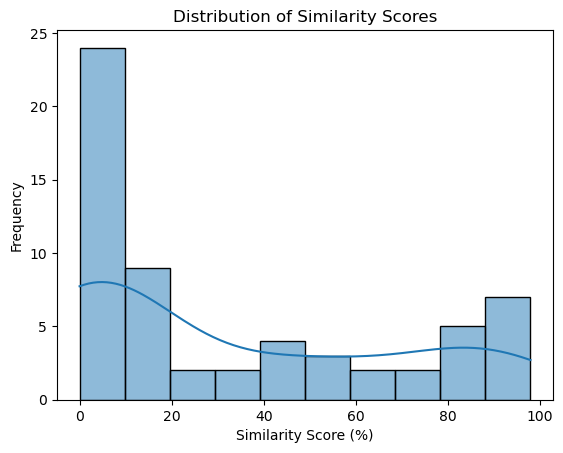

In [67]:
similarity_scores = [score for sublist in lookalike_data.values() for _, score in sublist]
sns.histplot(similarity_scores, bins=10, kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score (%)")
plt.ylabel("Frequency")
plt.show()

##### **Visualization of MSE Comparison**

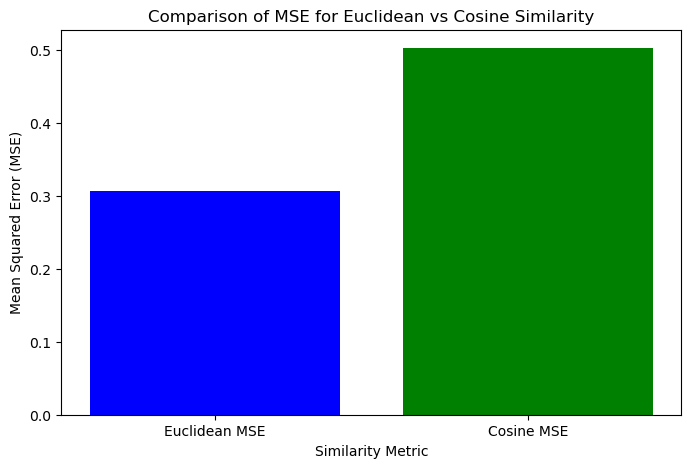

In [68]:
plt.figure(figsize=(8, 5))
mse_values = [mse_euclidean, mse_cosine]
mse_labels = ["Euclidean MSE", "Cosine MSE"]
plt.bar(mse_labels, mse_values, color=['blue', 'green'])
plt.xlabel("Similarity Metric")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of MSE for Euclidean vs Cosine Similarity")
plt.show()